In [94]:
#import the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pylab import rcParams

In [95]:
#load the dataset
df = pd.read_csv('datasets_302666_618181_AAPL.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-08-15,209.220001,210.740005,208.330002,210.240005,207.027420,28807600
1,2018-08-16,211.750000,213.809998,211.470001,213.320007,210.060333,28500400
2,2018-08-17,213.440002,217.949997,213.160004,217.580002,214.255234,35427000
3,2018-08-20,218.100006,219.179993,215.110001,215.460007,212.167633,30287700
4,2018-08-21,216.800003,217.190002,214.029999,215.039993,211.754028,26159800


In [96]:
#check the shape
df.shape

(251, 7)

In [97]:
#We will consider the volume of stocks as the depedent variable

In [98]:
df_vol = df[['Date', 'Volume']]
df_vol.head()

,Date,Volume
0,2018-08-15,28807600
1,2018-08-16,28500400
2,2018-08-17,35427000
3,2018-08-20,30287700
4,2018-08-21,26159800


In [99]:
#set date as the index column for doing time series analysisdf.set_index(0)
df_vol.dtypes

Date      object
Volume     int64
dtype: object

In [100]:
#We can observe that date is represented as object. We need to convert this to timestamp
df_vol['Date'] = df_vol['Date'].astype('datetime64')

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [101]:
df_vol.dtypes

Date      datetime64[ns]
Volume             int64
dtype: object

In [102]:
#We have converted the date to a datetime64 data type.

In [103]:
#check the first five rows
df_vol.head()

,Date,Volume
0,2018-08-15,28807600
1,2018-08-16,28500400
2,2018-08-17,35427000
3,2018-08-20,30287700
4,2018-08-21,26159800


In [104]:
#check the last five rows
df_vol.tail()

,Date,Volume
246,2019-08-08,27009500
247,2019-08-09,24619700
248,2019-08-12,22474900
249,2019-08-13,47218500
250,2019-08-14,36453100


In [105]:
#check for missing values
df_vol.isnull().sum()

Date      0
Volume    0
dtype: int64

In [106]:
#check the summary statistics
df_vol.describe()

,Volume
count,2.510000e+02
mean,3.289967e+07
std,1.385336e+07
min,1.136200e+07
25%,2.329740e+07
50%,2.985580e+07
75%,3.927970e+07
max,9.624670e+07


In [107]:
#We have no missing values in the data

In [108]:
#set the index column as the Date column
df_final = df_vol.set_index('Date')
df_final.head()

,Volume
Date,
2018-08-15,28807600
2018-08-16,28500400
2018-08-17,35427000
2018-08-20,30287700
2018-08-21,26159800


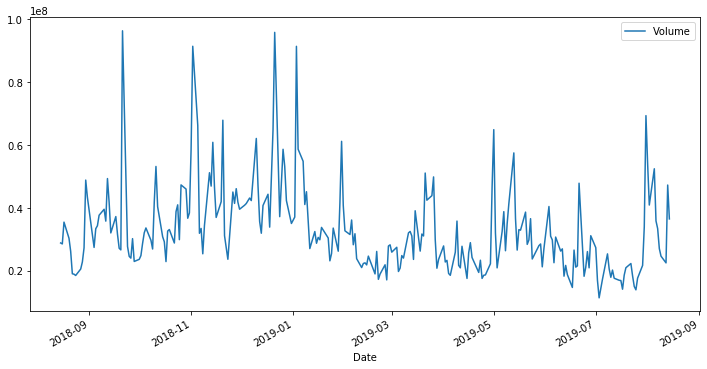

In [109]:
#plot the time series
rcParams['figure.figsize'] = 12,6
df_final.plot()

Looking at the above figure, it looks like the series is stationary.

In [110]:
#Let us check this assumption statistically using the Dickey Fuller test at alpha = 0.05

In [111]:
#Import the dickey fuller test
from statsmodels.tsa.stattools import adfuller

#formulate the null and alternate hypothesis
#H0 : Series is not stationary
#H1 : Series is stationary

#run the test
adfuller(df_final)

(-3.229302397627402,
 0.018349972893812905,
 6,
 244,
 {'1%': -3.457437824930831,
  '5%': -2.873459364726563,
  '10%': -2.573122099570008},
 8286.300083371007)

As the p value here (0.018) is less than 0.05, we reject the H0 that the time series is not stationary.

Therefore, we can conclude that the series is stationary at alpha = 0.05

In [112]:
#plot acf and pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

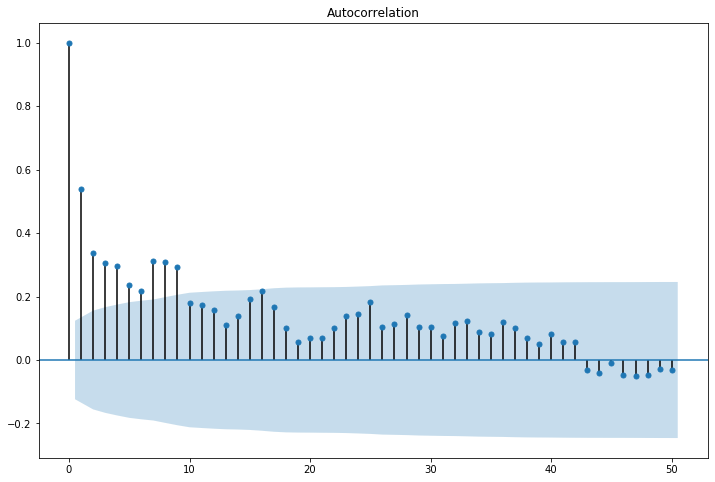

In [113]:
#plot acf
plt.figure(figsize=(12,8))
plot_acf(df_final,lags=50,  ax=plt.gca())
plt.show()

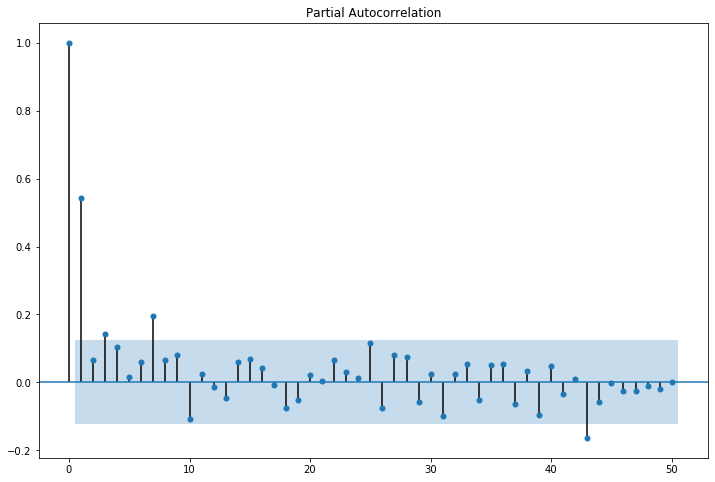

In [114]:
#plot pacf
plt.figure(figsize=(12,8))
plot_pacf(df_final, lags=50, ax=plt.gca())
plt.show()

In [115]:
#Seasonality is observed after every 5 days is visible

In [116]:
#Check for seasonality, trend, errors by decomposing the data

In [117]:
from statsmodels.tsa.seasonal import seasonal_decompose

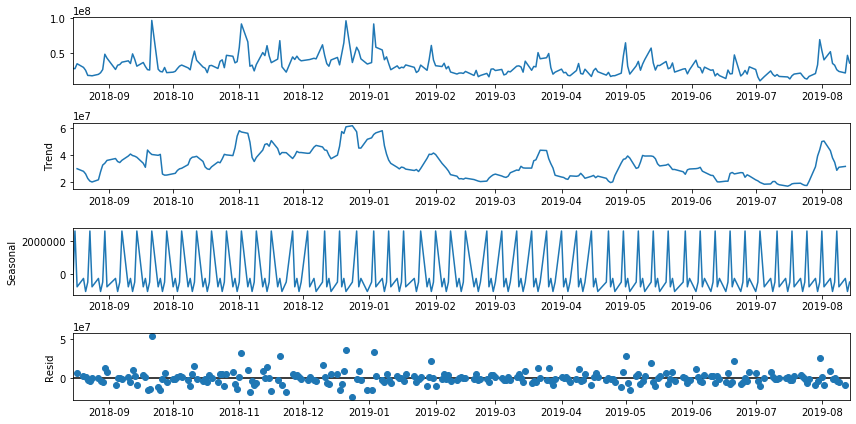

In [118]:
decomposition = seasonal_decompose(df_final, model='additive', period=5)
decomposition.plot()
plt.show()

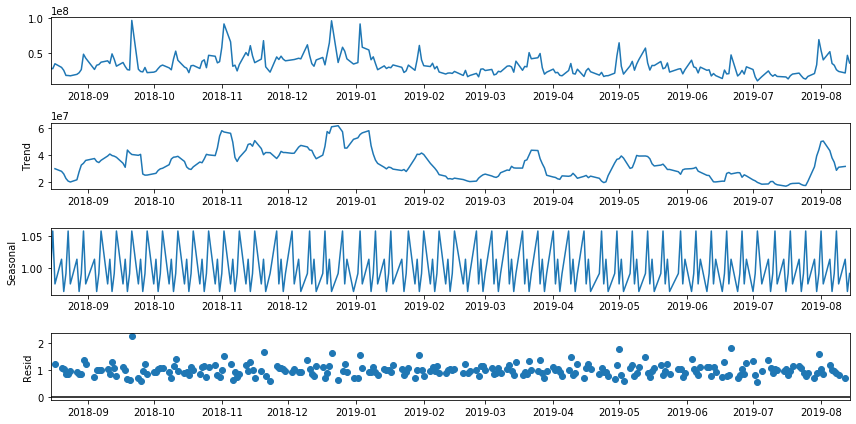

In [119]:
decomposition = seasonal_decompose(df_final, model='multiplicative', period=5)
decomposition.plot()
plt.show()

If the magnitude of the seasonal component changes with time, then the series is multiplicative. Otherwise, the series is additive.

Here, the series is additive based on above plots.

### Train Test Split 

In [120]:
#Before building the model, we will split the data into train and test set in the ratio 80:20

In [153]:
train = df[pd.to_datetime(df['Date']) < pd.to_datetime('2019-06-14')]
train.shape

(208, 7)

In [154]:
test = df[pd.to_datetime(df['Date']) >= pd.to_datetime('2019-06-14')]
test.shape

(43, 7)

In [155]:
train_vol = train[['Volume']]
test_vol = test[['Volume']]

In [156]:
train_vol.head()

,Volume
0,28807600
1,28500400
2,35427000
3,30287700
4,26159800


In [157]:
test_vol.head()

,Volume
208,18761500
209,14669100
210,26551000
211,21124200
212,21514000


### SARIMA Model

Since the data contains seasonality, we cannot use the ARIMA model.

Therefore, here we use the **SARIMA (Seasonal AutoRegressive Integrated Moving Average)** model 

In [129]:
#calculate the values of p,d,q

import itertools

p=q=range(0,3)
#no differencing so d is 0
d=range(0,1)
pdq = list(itertools.product(p,d,q))

model_pdq = [(x[0], x[1], x[2], 5) for x in list(itertools.product(p,d,q))]

In [130]:
df_sarima = pd.DataFrame(columns=['param','seasonal','AIC'])
df_sarima

,param,seasonal,AIC


In [158]:
#import statsmodels
import statsmodels.api as sm

for param in pdq:
    for param_seasonal in model_pdq:
        mod = sm.tsa.statespace.SARIMAX(train_vol, 
                                        order=param, 
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
        
        results_SARIMA = mod.fit()
        print('SARIMA{}x{}7 - AIC:{}'.format(param, param_seasonal, results_SARIMA.aic))
        df_sarima = df_sarima.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)

SARIMA(0, 0, 0)x(0, 0, 0, 5)7 - AIC:7803.902158390863
SARIMA(0, 0, 0)x(0, 0, 1, 5)7 - AIC:7516.843047531701
SARIMA(0, 0, 0)x(0, 0, 2, 5)7 - AIC:7311.0144743144865
SARIMA(0, 0, 0)x(1, 0, 0, 5)7 - AIC:7335.756112170122
SARIMA(0, 0, 0)x(1, 0, 1, 5)7 - AIC:7240.848774197257
SARIMA(0, 0, 0)x(1, 0, 2, 5)7 - AIC:7067.255496879539
SARIMA(0, 0, 0)x(2, 0, 0, 5)7 - AIC:7120.87452132768
SARIMA(0, 0, 0)x(2, 0, 1, 5)7 - AIC:7101.754037207331
SARIMA(0, 0, 0)x(2, 0, 2, 5)7 - AIC:7069.848627478243
SARIMA(0, 0, 1)x(0, 0, 0, 5)7 - AIC:7643.9036180653075
SARIMA(0, 0, 1)x(0, 0, 1, 5)7 - AIC:7432.848224473458
SARIMA(0, 0, 1)x(0, 0, 2, 5)7 - AIC:7241.978553953094
SARIMA(0, 0, 1)x(1, 0, 0, 5)7 - AIC:7482.677398931115
SARIMA(0, 0, 1)x(1, 0, 1, 5)7 - AIC:7401.24613135633
SARIMA(0, 0, 1)x(1, 0, 2, 5)7 - AIC:7218.723683044125
SARIMA(0, 0, 1)x(2, 0, 0, 5)7 - AIC:7295.3624889802195
SARIMA(0, 0, 1)x(2, 0, 1, 5)7 - AIC:7293.11300475528
SARIMA(0, 0, 1)x(2, 0, 2, 5)7 - AIC:7220.030979839118
SARIMA(0, 0, 2)x(0, 0, 0, 5)

D:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMA(2, 0, 1)x(2, 0, 2, 5)7 - AIC:6960.3234113636645
SARIMA(2, 0, 2)x(0, 0, 0, 5)7 - AIC:7265.5031243748
SARIMA(2, 0, 2)x(0, 0, 1, 5)7 - AIC:7092.752412992063
SARIMA(2, 0, 2)x(0, 0, 2, 5)7 - AIC:6916.638344279745
SARIMA(2, 0, 2)x(1, 0, 0, 5)7 - AIC:7127.911349481707
SARIMA(2, 0, 2)x(1, 0, 1, 5)7 - AIC:7105.977989745257
SARIMA(2, 0, 2)x(1, 0, 2, 5)7 - AIC:6931.61427790014
SARIMA(2, 0, 2)x(2, 0, 0, 5)7 - AIC:6952.429104210822


D:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMA(2, 0, 2)x(2, 0, 1, 5)7 - AIC:6953.669123473669
SARIMA(2, 0, 2)x(2, 0, 2, 5)7 - AIC:6926.058660665407


In [159]:
df_sarima.sort_values(by=['AIC']).head(5)

,param,seasonal,AIC
47,"(1, 0, 2)","(0, 0, 2, 5)",6637.695675
74,"(2, 0, 2)","(0, 0, 2, 5)",6639.512968
53,"(1, 0, 2)","(2, 0, 2, 5)",6647.449257
80,"(2, 0, 2)","(2, 0, 2, 5)",6649.227609
50,"(1, 0, 2)","(1, 0, 2, 5)",6652.770498


In [160]:
##SARIMA(1,0,2)(0,0,2,5) - AIC(6637.695675)
mod = sm.tsa.statespace.SARIMAX(train_vol, 
                                order=(1,0,2), 
                                seasonal_order=(0,0,2,5),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                            Volume   No. Observations:                  208
Model:             SARIMAX(1, 0, 2)x(0, 0, 2, 5)   Log Likelihood               -3451.425
Date:                           Wed, 17 Nov 2021   AIC                           6914.850
Time:                                   13:23:06   BIC                           6934.488
Sample:                                        0   HQIC                          6922.801
                                           - 208                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9984      0.004    225.715      0.000       0.990       1.007
ma.L1         -0.5659      0.056    -10.018

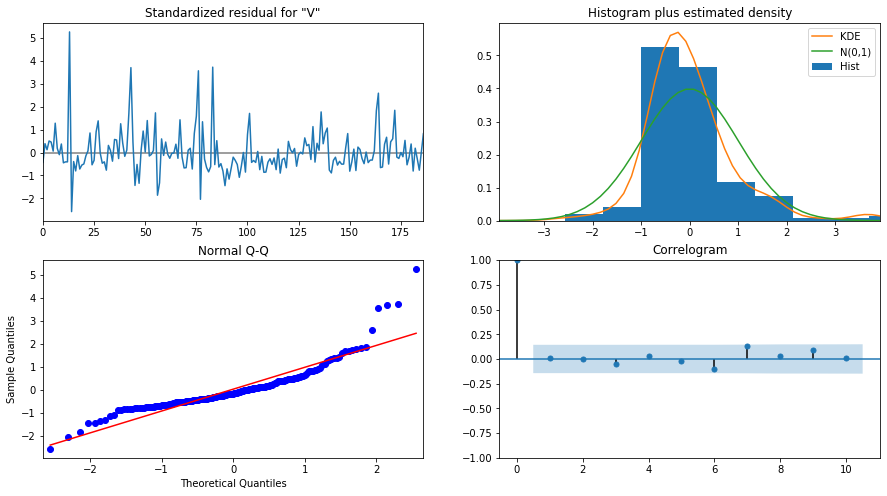

In [134]:
results.plot_diagnostics(figsize=(15,8))
plt.show()

In [161]:
#predict on test data
pred_SARIMA = results.get_forecast(steps=len(test_vol))
pred_SARIMA.predicted_mean

208    2.550885e+07
209    2.511654e+07
210    2.604792e+07
211    2.665969e+07
212    2.748734e+07
213    2.606264e+07
214    2.666559e+07
215    2.645973e+07
216    2.754758e+07
217    2.723556e+07
218    2.655605e+07
219    2.638127e+07
220    2.633857e+07
221    2.629595e+07
222    2.625339e+07
223    2.621090e+07
224    2.616848e+07
225    2.612613e+07
226    2.608385e+07
227    2.604164e+07
228    2.599949e+07
229    2.595742e+07
230    2.591541e+07
231    2.587347e+07
232    2.583159e+07
233    2.578979e+07
234    2.574805e+07
235    2.570638e+07
236    2.566478e+07
237    2.562324e+07
238    2.558178e+07
239    2.554037e+07
240    2.549904e+07
241    2.545777e+07
242    2.541657e+07
243    2.537544e+07
244    2.533437e+07
245    2.529337e+07
246    2.525244e+07
247    2.521157e+07
248    2.517077e+07
249    2.513003e+07
250    2.508936e+07
Name: predicted_mean, dtype: float64

In [163]:
#evaluate the model
from math import sqrt
from sklearn.metrics import mean_squared_error

rmse = sqrt(mean_squared_error(test_vol, pred_SARIMA.predicted_mean))
print(rmse)

12585663.604903977


In [164]:
#tabulate the results into a pandas dataframe
resultsDf = pd.DataFrame({'Test RMSE': rmse},
                        index=['SARIMA (1, 0, 2)(0, 0, 2,5)'])
resultsDf

,Test RMSE
"SARIMA (1, 0, 2)(0, 0, 2,5)",1.258566e+07


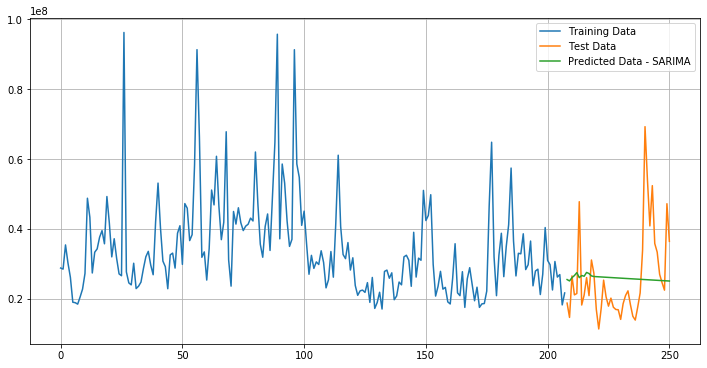

In [165]:
#plot the time series for SARIMA model
plt.plot(train_vol,label='Training Data')
plt.plot(test_vol,label='Test Data')
plt.plot(test_vol.index, pred_SARIMA.predicted_mean, label='Predicted Data - SARIMA')
plt.legend(loc='best')
plt.grid()
plt.show()

In [139]:
#The forecast is not as per the terms we want. Let's build the SARIMAX model.

### SARIMAX Model

In [167]:
#create the exogeneous variables

ex_train = train[['High','Low','Open','Close','Adj Close']]
ex_test = test[['High','Low','Open','Close','Adj Close']]

In [168]:
ex_train.head()

,High,Low,Open,Close,Adj Close
0,210.740005,208.330002,209.220001,210.240005,207.027420
1,213.809998,211.470001,211.750000,213.320007,210.060333
2,217.949997,213.160004,213.440002,217.580002,214.255234
3,219.179993,215.110001,218.100006,215.460007,212.167633
4,217.190002,214.029999,216.800003,215.039993,211.754028


In [169]:
ex_test.head()

,High,Low,Open,Close,Adj Close
208,193.589996,190.300003,191.550003,192.740005,192.010468
209,194.960007,192.169998,192.899994,193.889999,193.156113
210,200.289993,195.210007,196.050003,198.449997,197.698853
211,199.880005,197.309998,199.679993,197.869995,197.121048
212,200.610001,198.029999,200.369995,199.460007,198.705032


In [170]:
df_sarimax = pd.DataFrame(columns=['param','seasonal', 'AIC'])
df_sarimax

,param,seasonal,AIC


In [171]:
#use SARIMAX
for param in pdq:
    for param_seasonal in model_pdq:
        mod = sm.tsa.statespace.SARIMAX(train['Volume'],
                                        exog=ex_train,
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
            
        results_SARIMAX = mod.fit()
        print('SARIMAX{}{} - AIC:{}'.format(param, param_seasonal, results_SARIMAX.aic))
        df_sarimax = df_sarimax.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMAX.aic}, ignore_index=True)

SARIMAX(0, 0, 0)(0, 0, 0, 5) - AIC:8223.871573121145
SARIMAX(0, 0, 0)(0, 0, 1, 5) - AIC:7150.012329330128
SARIMAX(0, 0, 0)(0, 0, 2, 5) - AIC:6976.936374089528
SARIMAX(0, 0, 0)(1, 0, 0, 5) - AIC:7183.352555299982
SARIMAX(0, 0, 0)(1, 0, 1, 5) - AIC:7142.501073157819
SARIMAX(0, 0, 0)(1, 0, 2, 5) - AIC:6971.386530808137
SARIMAX(0, 0, 0)(2, 0, 0, 5) - AIC:7008.708300109602
SARIMAX(0, 0, 0)(2, 0, 1, 5) - AIC:7005.661088328619
SARIMAX(0, 0, 0)(2, 0, 2, 5) - AIC:6974.696417158304
SARIMAX(0, 0, 1)(0, 0, 0, 5) - AIC:7269.8676587493155
SARIMAX(0, 0, 1)(0, 0, 1, 5) - AIC:7096.567471166074
SARIMAX(0, 0, 1)(0, 0, 2, 5) - AIC:6925.383400113682
SARIMAX(0, 0, 1)(1, 0, 0, 5) - AIC:7165.524586607924
SARIMAX(0, 0, 1)(1, 0, 1, 5) - AIC:7093.869552062583
SARIMAX(0, 0, 1)(1, 0, 2, 5) - AIC:6923.107788743438
SARIMAX(0, 0, 1)(2, 0, 0, 5) - AIC:6993.875633673455
SARIMAX(0, 0, 1)(2, 0, 1, 5) - AIC:6992.56683324328
SARIMAX(0, 0, 1)(2, 0, 2, 5) - AIC:6924.252414057493
SARIMAX(0, 0, 2)(0, 0, 0, 5) - AIC:7231.668728

D:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMAX(2, 0, 1)(2, 0, 2, 5) - AIC:6911.239233053992
SARIMAX(2, 0, 2)(0, 0, 0, 5) - AIC:7219.368663250625
SARIMAX(2, 0, 2)(0, 0, 1, 5) - AIC:7048.153823000056
SARIMAX(2, 0, 2)(0, 0, 2, 5) - AIC:6876.406649953291
SARIMAX(2, 0, 2)(1, 0, 0, 5) - AIC:7082.4266957917
SARIMAX(2, 0, 2)(1, 0, 1, 5) - AIC:7050.106742452448
SARIMAX(2, 0, 2)(1, 0, 2, 5) - AIC:6877.526546135785
SARIMAX(2, 0, 2)(2, 0, 0, 5) - AIC:6912.297082297336
SARIMAX(2, 0, 2)(2, 0, 1, 5) - AIC:6913.322394622734
SARIMAX(2, 0, 2)(2, 0, 2, 5) - AIC:6878.730992825458


D:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [173]:
df_sarimax.sort_values(by=['AIC']).head(5)

,param,seasonal,AIC
47,"(1, 0, 2)","(0, 0, 2, 5)",6874.408342
53,"(1, 0, 2)","(2, 0, 2, 5)",6874.891246
50,"(1, 0, 2)","(1, 0, 2, 5)",6875.535133
74,"(2, 0, 2)","(0, 0, 2, 5)",6876.406650
77,"(2, 0, 2)","(1, 0, 2, 5)",6877.526546


In [174]:
## SARIMAX(1, 0, 2)(0, 0, 2, 5)

mod = sm.tsa.statespace.SARIMAX(train['Volume'],
                                exog=ex_train,
                                order=(1,0,2),
                                seasonal_order=(0,0,2,5),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                            Volume   No. Observations:                  208
Model:             SARIMAX(1, 0, 2)x(0, 0, 2, 5)   Log Likelihood               -3426.204
Date:                           Wed, 17 Nov 2021   AIC                           6874.408
Time:                                   13:28:07   BIC                           6910.411
Sample:                                        0   HQIC                          6888.986
                                           - 208                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
High        5.373e+06   8.08e+04     66.537      0.000    5.21e+06    5.53e+06
Low        -4.362e+06   2.01e+04   -216.608

In [179]:
#predict on the test set
pred_SARIMAX = results.get_forecast(steps=len(test),exog=ex_test)
pred_SARIMAX.predicted_mean

208    2.494819e+07
209    2.380965e+07
210    3.450549e+07
211    2.411500e+07
212    2.374211e+07
213    2.526271e+07
214    2.165415e+07
215    3.190705e+07
216    2.896545e+07
217    2.243773e+07
218    2.398908e+07
219    3.173890e+07
220    2.050586e+07
221    2.025856e+07
222    2.303258e+07
223    2.678733e+07
224    2.474576e+07
225    2.286083e+07
226    2.705074e+07
227    2.158638e+07
228    2.208477e+07
229    2.622401e+07
230    2.285990e+07
231    2.327080e+07
232    3.510575e+07
233    2.969589e+07
234    2.102584e+07
235    2.309279e+07
236    2.693038e+07
237    2.727850e+07
238    2.478736e+07
239    2.796095e+07
240    6.664417e+07
241    7.283412e+07
242    3.720701e+07
243    4.475027e+07
244    3.218904e+07
245    3.945433e+07
246    3.238843e+07
247    3.108755e+07
248    2.846421e+07
249    6.938085e+07
250    3.491365e+07
Name: predicted_mean, dtype: float64

In [176]:
rmse = sqrt(mean_squared_error(test.Volume,pred_SARIMAX.predicted_mean))
print(rmse)

8466439.156436862


In [177]:
#tabulate the results into a pandas dataframe
resultsDf_temp = pd.DataFrame({'Test RMSE': rmse},
                        index=['SARIMAX (1, 0, 2)(0, 0, 2, 5)'])

resultsDf = pd.concat([resultsDf, resultsDf_temp])
resultsDf

,Test RMSE
"SARIMA (1, 0, 2)(0, 0, 2,5)",1.258566e+07
"SARIMAX (1, 0, 2)(0, 0, 2, 5)",8.466439e+06


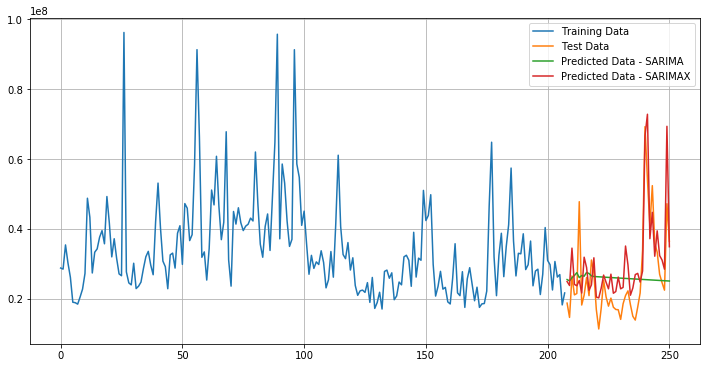

In [183]:
#plot the time series for SARIMAX model
plt.plot(train_vol,label='Training Data')
plt.plot(test_vol,label='Test Data')
plt.plot(test_vol.index, pred_SARIMA.predicted_mean, label='Predicted Data - SARIMA')
plt.plot(test_vol.index, pred_SARIMAX.predicted_mean, label='Predicted Data - SARIMAX')
plt.legend(loc='best')
plt.grid()
plt.show()

We can observe that as compared to the SARIMA model, the SARIMAX model has a lower rmse value and better fit.

### Time Series using Facebook Prophet library

In [191]:
#import the required libraries
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

In [188]:
#create dataframe with required variables
df_prophet = pd.DataFrame()
#prophet requires us to set the datetime column as ds and dependent variable as y
df_prophet['ds'] = pd.to_datetime(df['Date'])
df_prophet['y'] = df['Volume']
df_prophet['High']= df['High']
df_prophet['Low']=df['Low']

df_prophet.head()

,ds,y,High,Low
0,2018-08-15,28807600,210.740005,208.330002
1,2018-08-16,28500400,213.809998,211.470001
2,2018-08-17,35427000,217.949997,213.160004
3,2018-08-20,30287700,219.179993,215.110001
4,2018-08-21,26159800,217.190002,214.029999


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


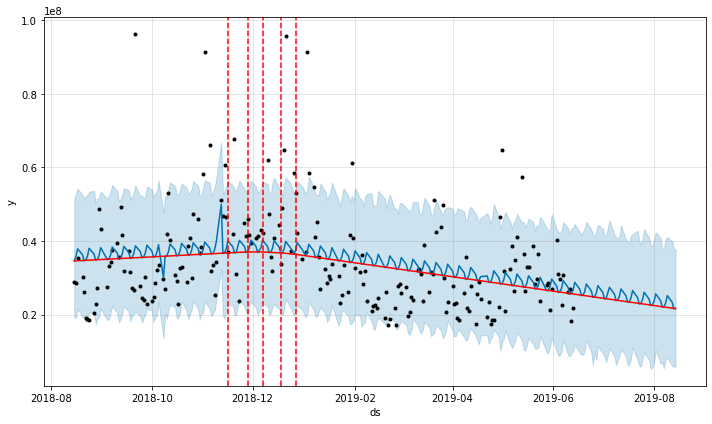

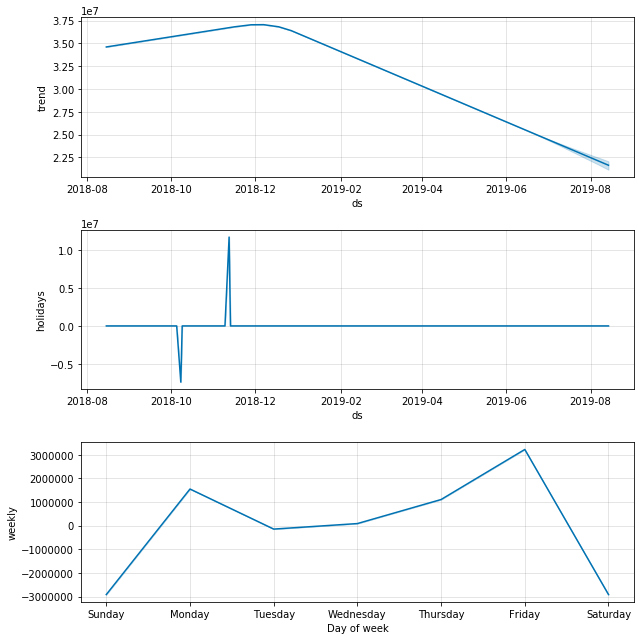

In [195]:
#initialize the model
prophet=Prophet(seasonality_mode='additive', weekly_seasonality=True)
#add the country holidays to account for unnatural events
prophet.add_country_holidays(country_name='US')
#fit the model on the data
prophet.fit(df_prophet[df_prophet['ds'] <= pd.to_datetime('2019-06-13')])
#create future dataframe for next 43 days
future = prophet.make_future_dataframe(periods=43, freq=us_bd)
#make the predictions
forecast = prophet.predict(future)

#plot the predictions
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()
fig2 = prophet.plot_components(forecast)
plt.show()

Prophet has included the original data as the black dots and the blue line is the forecast model.

The light blue area is the confidence interval. Using the add_changepoints_to_plot function added the red lines; the vertical dashed lines are changepoints Prophet identified where the trend changed, and the solid red line is the trend with all seasonality removed. 


The components plot consists of 3 sections: the trend, the holidays, and the seasonality. The sum of those 3 components account for the entirety of the model in fact. The trend is simply what the data is showing if you subtract out all of the other components. 

The holidays plot shows the effect of all of the holidays included in the model. Holidays, as implemented in Prophet, can be thought of as unnatural events when the trend will deviate from the baseline but return once the event is over.

The weekly seasonality component shows the change in volume over 
the week, but with a steep decline on the weekend. 

In [196]:
#get the predictions
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Columbus Day,...,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-08-15,3.460496e+07,1.928922e+07,5.145097e+07,3.460496e+07,3.460496e+07,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,8.940846e+04,8.940846e+04,8.940846e+04,0.0,0.0,0.0,3.469436e+07
1,2018-08-16,3.462871e+07,1.907324e+07,5.269559e+07,3.462871e+07,3.462871e+07,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.107985e+06,1.107985e+06,1.107985e+06,0.0,0.0,0.0,3.573669e+07
2,2018-08-17,3.465246e+07,2.170570e+07,5.429870e+07,3.465246e+07,3.465246e+07,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.228482e+06,3.228482e+06,3.228482e+06,0.0,0.0,0.0,3.788094e+07
3,2018-08-20,3.472371e+07,1.931568e+07,5.260834e+07,3.472371e+07,3.472371e+07,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.552626e+06,1.552626e+06,1.552626e+06,0.0,0.0,0.0,3.627634e+07
4,2018-08-21,3.474746e+07,1.913007e+07,5.137574e+07,3.474746e+07,3.474746e+07,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.444133e+05,-1.444133e+05,-1.444133e+05,0.0,0.0,0.0,3.460305e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,2019-08-08,2.202957e+07,7.894714e+06,4.051734e+07,2.161796e+07,2.240869e+07,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.107985e+06,1.107985e+06,1.107985e+06,0.0,0.0,0.0,2.313755e+07
247,2019-08-09,2.196542e+07,8.214435e+06,4.109657e+07,2.153744e+07,2.235384e+07,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.228482e+06,3.228482e+06,3.228482e+06,0.0,0.0,0.0,2.519390e+07
248,2019-08-12,2.177296e+07,6.092703e+06,3.998124e+07,2.130410e+07,2.218816e+07,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.552626e+06,1.552626e+06,1.552626e+06,0.0,0.0,0.0,2.332558e+07
249,2019-08-13,2.170881e+07,5.782928e+06,3.778633e+07,2.122946e+07,2.213347e+07,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.444133e+05,-1.444133e+05,-1.444133e+05,0.0,0.0,0.0,2.156439e+07


In [197]:
#evaluate the predictions
rmse = sqrt(mean_squared_error(test_vol['Volume'], forecast.tail(43)['yhat']))
print(rmse)

13033810.339122457


In [198]:
#tabulate the results
resultsDf_temp3 = pd.DataFrame({'Test RMSE': rmse}
                              ,index=['Prophet'])

resultsDf = pd.concat([resultsDf, resultsDf_temp3])
resultsDf

,Test RMSE
"SARIMA (1, 0, 2)(0, 0, 2,5)",1.258566e+07
"SARIMAX (1, 0, 2)(0, 0, 2, 5)",8.466439e+06
Prophet,1.303381e+07


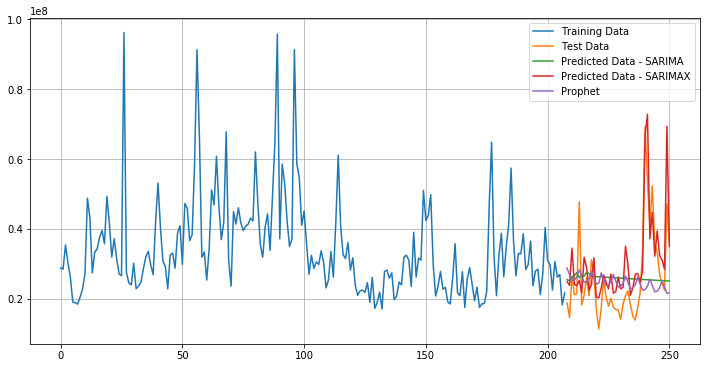

In [200]:
#plot the graph
plt.plot(train_vol,label='Training Data')
plt.plot(test_vol,label='Test Data')
plt.plot(test_vol.index,pred_SARIMA.predicted_mean,label='Predicted Data - SARIMA')
plt.plot(test_vol.index,pred_SARIMAX.predicted_mean,label='Predicted Data - SARIMAX')
plt.plot(test_vol.index,forecast.tail(43)['yhat'],label='Prophet')
plt.legend(loc='best')
plt.grid()
plt.show()

If you have independent variables apart from the target forcasted variables, you can add thems as a regressor variables.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


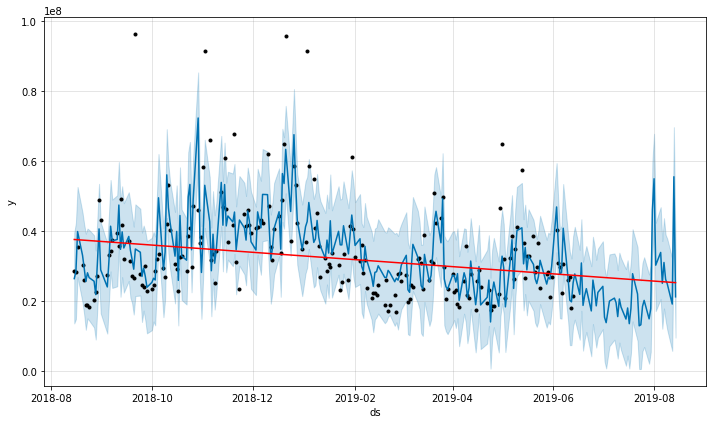

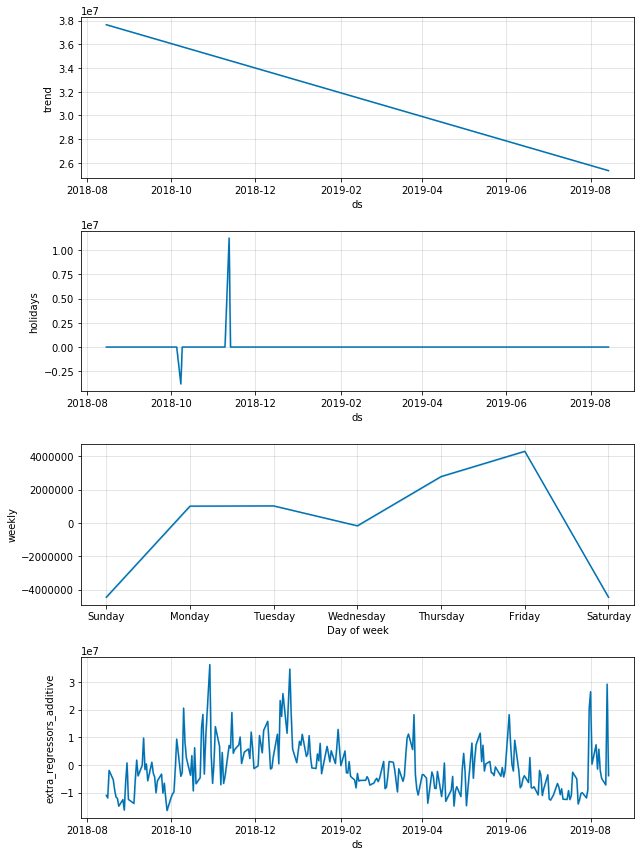

In [201]:
#repeat the same code with additional regressors
prophet=Prophet()
prophet.add_country_holidays(country_name='US')
prophet.add_regressor('High')
prophet.add_regressor('Low')

prophet.fit(df_prophet[df_prophet['ds'] < pd.to_datetime('2019-06-14')])
future = prophet.make_future_dataframe(periods=43, freq=us_bd)
future['High']= df_prophet['High']
future['Low']= df_prophet['Low']
forecast = prophet.predict(future)

fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()
fig2 = prophet.plot_components(forecast)
plt.show()


In [202]:
#calculate the rmse
rmse = sqrt(mean_squared_error(test_vol['Volume'], forecast.tail(43)['yhat']))
print(rmse)

7986690.518454521


In [203]:
resultsDf_temp4 = pd.DataFrame({'Test RMSE': rmse}
                           ,index=['Prophet - with exog variables'])

resultsDf = pd.concat([resultsDf, resultsDf_temp4])
resultsDf

,Test RMSE
"SARIMA (1, 0, 2)(0, 0, 2,5)",1.258566e+07
"SARIMAX (1, 0, 2)(0, 0, 2, 5)",8.466439e+06
Prophet,1.303381e+07
Prophet - with exog variables,7.986691e+06


In [ ]:
#we can see that the rmse has reduced significantly

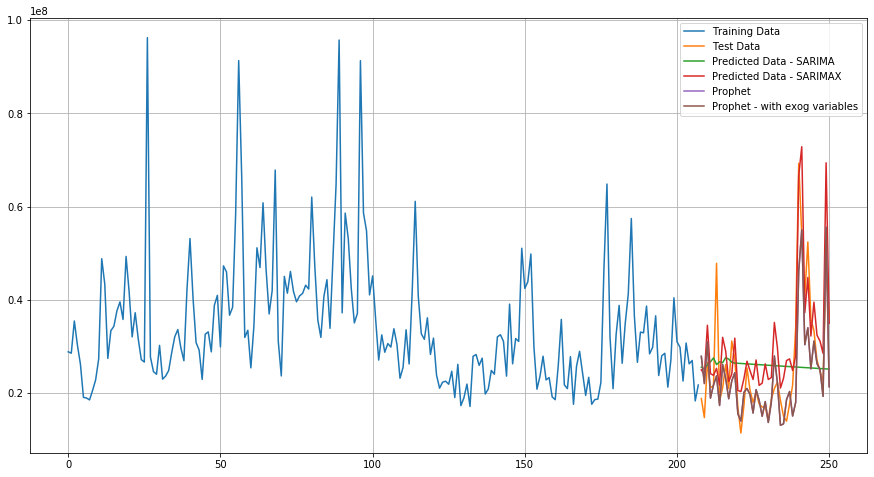

In [205]:
plt.figure(figsize=(15,8))
plt.plot(train_vol,label='Training Data')
plt.plot(test_vol,label='Test Data')
plt.plot(test_vol.index,pred_SARIMA.predicted_mean,label='Predicted Data - SARIMA')
plt.plot(test_vol.index,pred_SARIMAX.predicted_mean,label='Predicted Data - SARIMAX')
plt.plot(test_vol.index,forecast.tail(43)['yhat'],label='Prophet')
plt.plot(test_vol.index,forecast.tail(43)['yhat'],label='Prophet - with exog variables')
plt.legend(loc='best')
plt.grid()
plt.show()

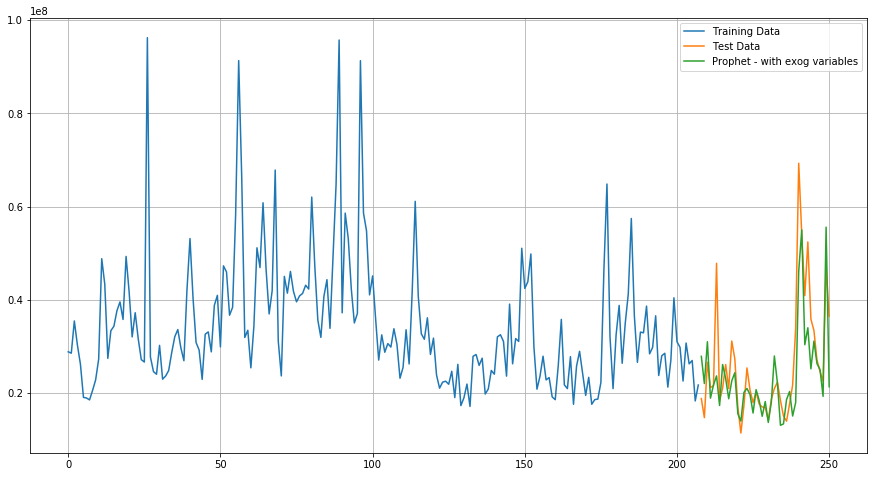

In [206]:
#plot test data only with prophet - exog variables
plt.figure(figsize=(15,8))
plt.plot(train_vol,label='Training Data')
plt.plot(test_vol,label='Test Data')
plt.plot(test_vol.index,forecast.tail(43)['yhat'],label='Prophet - with exog variables')
plt.legend(loc='best')
plt.grid()
plt.show()

In [229]:
#perform cross validation
#Cross Validation of developed time series model. This is a function for cross validation. It creates train and test dataset. Initial days define train data
#and horizon data define test data. Period defines the forecast
from fbprophet.diagnostics import cross_validation

df_cv = cross_validation(prophet, initial = '208 days', period='15 days', horizon='30 days')
df_cv.head()

INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-03-15 00:00:00 and 2019-05-14 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-03-18,1.923809e+07,6.044322e+06,3.328761e+07,26219800,2019-03-15
1,2019-03-19,2.064879e+07,6.574641e+06,3.447763e+07,31646400,2019-03-15
2,2019-03-20,2.653025e+07,1.346322e+07,4.052711e+07,31035200,2019-03-15
3,2019-03-21,3.566383e+07,2.182590e+07,5.068218e+07,51034200,2019-03-15
4,2019-03-22,3.920868e+07,2.519386e+07,5.253985e+07,42407700,2019-03-15


In [230]:
#evaluate using performance metrics
from fbprophet.diagnostics import performance_metrics

df_perf = performance_metrics(df_cv)
df_perf.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,1.507859e+14,1.227949e+07,7.523399e+06,0.190443,0.125429,0.866667
1,4 days,5.913903e+13,7.690190e+06,5.252334e+06,0.174380,0.125429,0.975000
2,5 days,3.230701e+13,5.683926e+06,4.816354e+06,0.185461,0.155136,1.000000
3,6 days,5.647104e+13,7.514721e+06,6.171977e+06,0.204601,0.227130,0.900000
4,7 days,4.696092e+13,6.852804e+06,5.379492e+06,0.168691,0.114344,0.900000


D:\Anaconda\lib\site-packages\fbprophet\plot.py:526: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
D:\Anaconda\lib\site-packages\fbprophet\plot.py:527: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


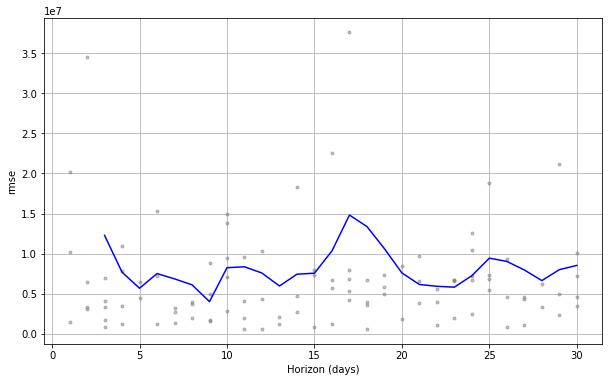

In [231]:
#plot the metrics
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')

Time series model performance: Cross validation performance metrics can be visualized with plot_cross_validation_metric,
here shown for RMSE. 

Dots show the error for each prediction in df_cv. The blue line shows the RMSE,
where the mean is taken over a rolling window of the dots.